<a href="https://colab.research.google.com/github/ananthu-raj/Image-Classification-Experimentation/blob/main/Chess_Image_Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Chess Image Classification**

In [ ]:
# Importing libraries
#!pip install tensorflow-gpu
import os
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import seaborn as sns
import tensorflow as tf
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers.convolutional import Conv2D
from keras.layers import Dense
from keras.layers.convolutional import MaxPooling2D
from keras.layers import Flatten
from keras.layers import Dropout
from tensorflow.keras import  layers, models
import tqdm
import numpy as np
from sklearn.metrics import plot_confusion_matrix
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report

In [ ]:
from tensorflow.keras.layers import Conv2D,Dense,MaxPooling2D,Dropout,Flatten,Activation,MaxPool2D,BatchNormalization

In [ ]:
# Checking the GPU Version
!nvidia-smi

Sat Nov 12 16:23:02 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   48C    P0    27W /  70W |   7030MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Basic EDA and Visualisations

['/content/drive/MyDrive/Chess/Rook', '/content/drive/MyDrive/Chess/Bishop', '/content/drive/MyDrive/Chess/Queen', '/content/drive/MyDrive/Chess/Pawn', '/content/drive/MyDrive/Chess/Knight']


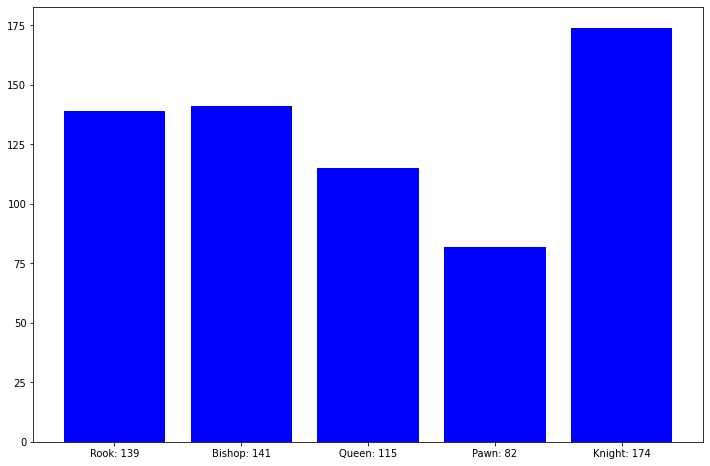

In [ ]:
# To visualise the number of each chess pieces
dirname = '/content/drive/MyDrive/Chess'
dir_chess_folders = os.listdir(dirname)
dir_chess_paths = [os.path.join(dirname, path) for path in dir_chess_folders]
print(dir_chess_paths)

chess_dic = {}
for path in dir_chess_paths:
    head, tail = os.path.split(path)
    chess_dic[tail] = len(os.listdir(path))
label_list = ["{}: {}".format(key, chess_dic[key]) for key in chess_dic]
plt.figure(figsize=(12, 8))
plt.bar(range(len(chess_dic)), list(chess_dic.values()), color="blue")
plt.xticks(range(len(chess_dic)), list(label_list))
plt.show();

In [ ]:
# Checking Resolutions of Every Image
# Reference : https://stackoverflow.com/questions/1507084/how-to-check-dimensions-of-all-images-in-a-directory-using-python
from PIL import Image 

folder_images = dirname
size_images = dict()

for dirpath, _, filenames in os.walk(folder_images):
    for path_image in filenames:
        image = os.path.abspath(os.path.join(dirpath, path_image))
        with Image.open(image) as img:
            width, heigth = img.size
            size_images[path_image] = {'width': width, 'height': heigth}
resolutions = pd.DataFrame.from_dict(size_images, orient ='index')
resolutions

,width,height
00000216_resized.jpg,224,224
00000052_resized.jpg,224,224
00000053_resized.jpg,224,224
00000168_resized.jpg,224,224
00000104_resized.jpg,224,224
...,...,...
00000326_resized.jpg,224,224
00000310_resized.jpg,224,224
00000162_resized.jpg,224,224
00000322_resized.jpg,224,224


In [ ]:
uniq_widths = pd.unique(resolutions.width)
uniq_heights = pd.unique(resolutions.height)
print(f"Unique resolution widths are: {uniq_widths}")
print(f"Unique resolution heights are: {uniq_heights}")

Unique resolution widths are: [224]
Unique resolution heights are: [224]


### Thus we observe that all the images have been already reszied and all them have the same resolution of 224x224

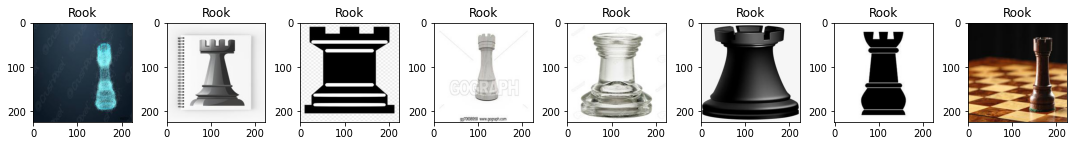

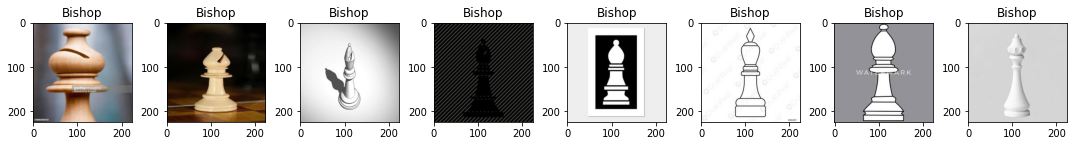

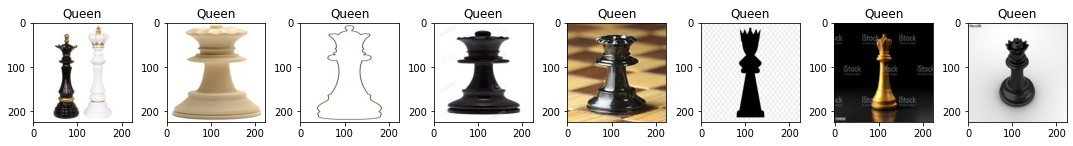

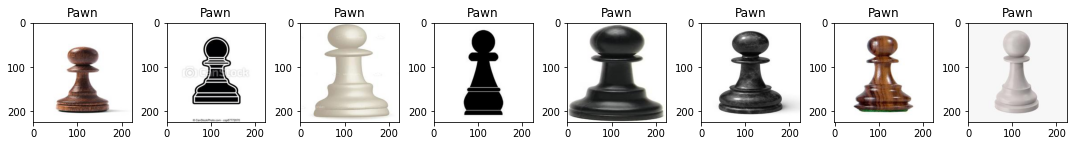

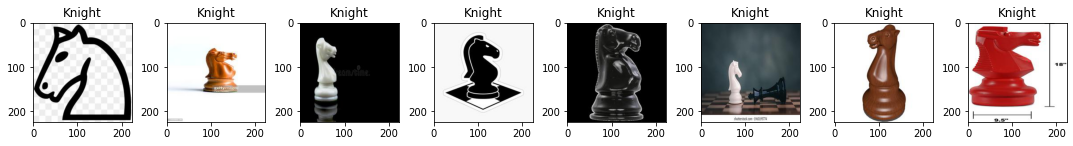

In [ ]:
def plot_imgs(item_dir, title=" ", num_imgs=4, cmap='viridis'):
    all_item_dirs = os.listdir(item_dir)
    item_files = [os.path.join(item_dir, file) for file in all_item_dirs][:num_imgs]

    plt.figure(figsize=(15, 15))
    for idx, img_path in enumerate(item_files):
        plt.subplot(8, 8, idx+1)
        img = plt.imread(img_path, 0)
        plt.title(title)
        plt.imshow(img, cmap=cmap)

    plt.tight_layout()
for path in dir_chess_paths:
    head, tail = os.path.split(path)
    plot_imgs(path, tail, 8)

In [ ]:
# Conventional Training and Test Sets
x=np.concatenate([train_generator.next()[0] for i in range(train_generator.__len__())])
y=np.concatenate([train_generator.next()[1] for i in range(train_generator.__len__())])
print(x.shape)
print(y.shape)
from sklearn.model_selection import train_test_split
X_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2)

(458, 150, 150, 3)
(458, 5)


# 1. CNN

In [ ]:
img_size_h = 150
img_size_w = 150

# Normalization of RGB values of the images
train_datagen = ImageDataGenerator(rescale=1. / 255, validation_split=0.3)
input_shape = (img_size_h, img_size_w, 3)
batch_size = 16
train_generator = train_datagen.flow_from_directory(
    dirname,
    target_size=(img_size_h, img_size_w),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='training',
    shuffle=True,  # we shuffle our images for better performance
    seed=8)
validation_generator = train_datagen.flow_from_directory(
    dirname,
    target_size=(img_size_h, img_size_w),
    color_mode='rgb',
    batch_size=batch_size,
    class_mode='categorical',
    subset='validation',
    shuffle=True,
    seed=7)

Found 458 images belonging to 5 classes.
Found 193 images belonging to 5 classes.


In [ ]:
model = Sequential([

    Conv2D(16, (3, 3), input_shape=input_shape, padding='same', activation='relu'),
    Conv2D(32, (3, 3), padding='same', activation='relu'),
    MaxPool2D((2, 2)),
    Dropout(0.2),

    Conv2D(64, (3, 3), padding='same', activation='relu'),
    #Conv2D(128, (3, 3), padding='same', activation='relu'),
    MaxPool2D((2, 2)),
    Dropout(0.3),

    Flatten(),

    Dense(128, activation='relu'),
    Dropout(0.2),
    Dense(5, activation='softmax')

])

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='sgd', metrics=['accuracy'])
model.summary()

Model: "sequential_9"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_121 (Conv2D)         (None, 150, 150, 16)      448       
                                                                 
 conv2d_122 (Conv2D)         (None, 150, 150, 32)      4640      
                                                                 
 max_pooling2d_22 (MaxPoolin  (None, 75, 75, 32)       0         
 g2D)                                                            
                                                                 
 dropout_42 (Dropout)        (None, 75, 75, 32)        0         
                                                                 
 conv2d_123 (Conv2D)         (None, 75, 75, 64)        18496     
                                                                 
 max_pooling2d_23 (MaxPoolin  (None, 37, 37, 64)       0         
 g2D)                                                 

In [ ]:
epochs = 25
history = model.fit(train_generator, epochs=epochs, validation_data=validation_generator)

Epoch 1/25


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  


29/29 [==============================] - 2s 67ms/step - loss: 1.6793 - accuracy: 0.2052 - val_loss: 1.5908 - val_accuracy: 0.2953
Epoch 2/25
29/29 [==============================] - 2s 61ms/step - loss: 1.5903 - accuracy: 0.2489 - val_loss: 1.5879 - val_accuracy: 0.2280
Epoch 3/25
29/29 [==============================] - 2s 60ms/step - loss: 1.5832 - accuracy: 0.2751 - val_loss: 1.5811 - val_accuracy: 0.2798
Epoch 4/25
29/29 [==============================] - 2s 62ms/step - loss: 1.5717 - accuracy: 0.2904 - val_loss: 1.5740 - val_accuracy: 0.2953
Epoch 5/25
29/29 [==============================] - 2s 60ms/step - loss: 1.5680 - accuracy: 0.3122 - val_loss: 1.5717 - val_accuracy: 0.3005
Epoch 6/25
29/29 [==============================] - 2s 60ms/step - loss: 1.5572 - accuracy: 0.3210 - val_loss: 1.5638 - val_accuracy: 0.3782
Epoch 7/25
29/29 [==============================] - 2s 62ms/step - loss: 1.5460 - accuracy: 0.3341 - val_loss: 1.5493 - val_accuracy: 0.3575
Epoch 8/25
29/29 [======

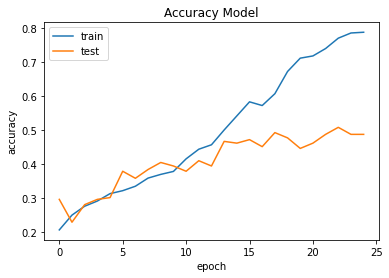

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

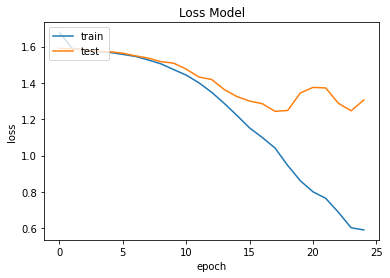

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **2. VGG 16**

In [ ]:
from tensorflow.keras.applications.vgg16 import VGG16

base_model = VGG16(input_shape = (150, 150, 3), # Shape of our images
include_top = False, # Leave out the last fully connected layer
weights = 'imagenet')

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
# Flatten the output layer to 1 dimension
x = layers.Flatten()(base_model.output)

# Add a fully connected layer with 512 hidden units and ReLU activation
x = layers.Dense(512, activation='relu')(x)

# Add a dropout rate of 0.5
x = layers.Dropout(0.5)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(1, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = tf.keras.optimizers.RMSprop(learning_rate=0.00001), loss = 'binary_crossentropy',metrics = ['acc'])

In [ ]:
vgghist = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 5, epochs = 10)


Epoch 1/10
5/5 [==============================] - 6s 523ms/step - loss: 0.8107 - acc: 0.6800 - val_loss: 0.5941 - val_acc: 0.7503
Epoch 2/10
5/5 [==============================] - 1s 194ms/step - loss: 0.7864 - acc: 0.6950 - val_loss: 0.6048 - val_acc: 0.7876
Epoch 3/10
5/5 [==============================] - 1s 193ms/step - loss: 0.8530 - acc: 0.6500 - val_loss: 0.6934 - val_acc: 0.7938
Epoch 4/10
5/5 [==============================] - 1s 195ms/step - loss: 0.7768 - acc: 0.7325 - val_loss: 0.5784 - val_acc: 0.7720
Epoch 5/10
5/5 [==============================] - 1s 203ms/step - loss: 0.7341 - acc: 0.7175 - val_loss: 0.5792 - val_acc: 0.7440
Epoch 6/10
5/5 [==============================] - 1s 206ms/step - loss: 0.7686 - acc: 0.6950 - val_loss: 0.6895 - val_acc: 0.8000
Epoch 7/10
5/5 [==============================] - 1s 200ms/step - loss: 0.7238 - acc: 0.7325 - val_loss: 0.5823 - val_acc: 0.7969
Epoch 8/10
5/5 [==============================] - 1s 204ms/step - loss: 0.7281 - acc: 0.73

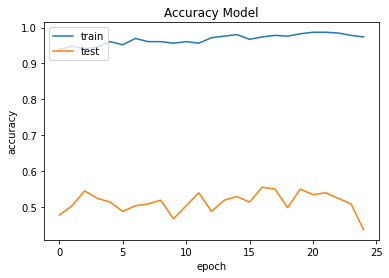

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

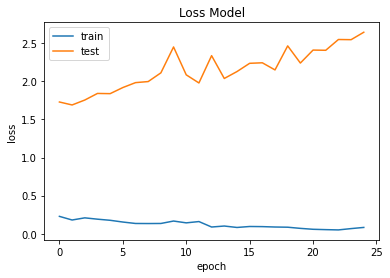

In [ ]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Loss Model')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **3. Inception**

In [ ]:
from tensorflow.keras.applications.inception_v3 import InceptionV3
base_model = InceptionV3(input_shape = (150, 150, 3), include_top = False, weights = 'imagenet')

87910968/87910968 [==============================] - 5s 0us/step


In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from tensorflow.keras.optimizers import RMSprop

x = layers.Flatten()(base_model.output)
x = layers.Dense(1024, activation='relu')(x)
x = layers.Dropout(0.2)(x)

# Add a final sigmoid layer with 1 node for classification output
x = layers.Dense(5, activation='sigmoid')(x)

model = tf.keras.models.Model(base_model.input, x)

model.compile(optimizer = RMSprop(lr=0.0001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
inc_history = model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 20, epochs = 20)

Epoch 1/20
20/20 [==============================] - 2s 80ms/step - loss: 0.0537 - acc: 0.9745 - val_loss: 0.2678 - val_acc: 0.7876
Epoch 2/20
20/20 [==============================] - 2s 76ms/step - loss: 0.1078 - acc: 0.9459 - val_loss: 0.2603 - val_acc: 0.7979
Epoch 3/20
20/20 [==============================] - 2s 75ms/step - loss: 0.0981 - acc: 0.9554 - val_loss: 0.4924 - val_acc: 0.7254
Epoch 4/20
20/20 [==============================] - 2s 78ms/step - loss: 0.0477 - acc: 0.9750 - val_loss: 0.3846 - val_acc: 0.7617
Epoch 5/20
20/20 [==============================] - 2s 78ms/step - loss: 0.0779 - acc: 0.9682 - val_loss: 0.3015 - val_acc: 0.8083
Epoch 6/20
20/20 [==============================] - 2s 77ms/step - loss: 0.0497 - acc: 0.9688 - val_loss: 0.4115 - val_acc: 0.7720
Epoch 7/20
20/20 [==============================] - 2s 77ms/step - loss: 0.0416 - acc: 0.9906 - val_loss: 0.5161 - val_acc: 0.7358
Epoch 8/20
20/20 [==============================] - 1s 75ms/step - loss: 0.0818 - a

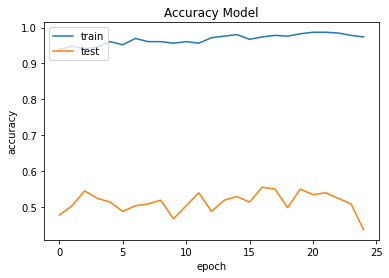

In [ ]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Accuracy Model')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

## **3. ResNet50**

In [ ]:
from tensorflow.keras.applications import ResNet50

base_model = ResNet50(input_shape=(150, 150,3), include_top=False, weights="imagenet")

In [ ]:
for layer in base_model.layers:
    layer.trainable = False

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM, BatchNormalization
from keras.callbacks import TensorBoard
from keras.callbacks import ModelCheckpoint


In [ ]:
from tensorflow.keras.applications import ResNet50

from tensorflow.python.keras.layers import Dense, Flatten, GlobalAveragePooling2D


base_model = Sequential()
base_model.add(ResNet50(include_top=False, weights='imagenet', pooling='max'))
base_model.add(Dense(1, activation='sigmoid'))

In [ ]:
base_model.compile(optimizer = tf.keras.optimizers.SGD(lr=0.00001), loss = 'binary_crossentropy', metrics = ['acc'])

In [ ]:
resnet_history = base_model.fit(train_generator, validation_data = validation_generator, steps_per_epoch = 15, epochs = 10)

Epoch 1/10
15/15 [==============================] - 9s 225ms/step - loss: 0.9106 - acc: 0.7050 - val_loss: 1.3998 - val_acc: 0.3648
Epoch 2/10
15/15 [==============================] - 2s 152ms/step - loss: 0.9737 - acc: 0.6825 - val_loss: 1.4435 - val_acc: 0.3865
Epoch 3/10
15/15 [==============================] - 2s 150ms/step - loss: 0.9698 - acc: 0.6975 - val_loss: 1.4907 - val_acc: 0.4021
Epoch 4/10
15/15 [==============================] - 2s 152ms/step - loss: 1.0206 - acc: 0.6725 - val_loss: 1.4255 - val_acc: 0.4363
Epoch 5/10
15/15 [==============================] - 3s 171ms/step - loss: 1.0010 - acc: 0.6897 - val_loss: 1.4568 - val_acc: 0.4269
Epoch 6/10
15/15 [==============================] - 2s 154ms/step - loss: 0.9562 - acc: 0.7100 - val_loss: 1.4606 - val_acc: 0.4332
Epoch 7/10
15/15 [==============================] - 2s 158ms/step - loss: 1.0291 - acc: 0.7000 - val_loss: 1.4841 - val_acc: 0.4363
Epoch 8/10
15/15 [==============================] - 3s 176ms/step - loss: 0.